100 entrées simulées insérées avec succès.


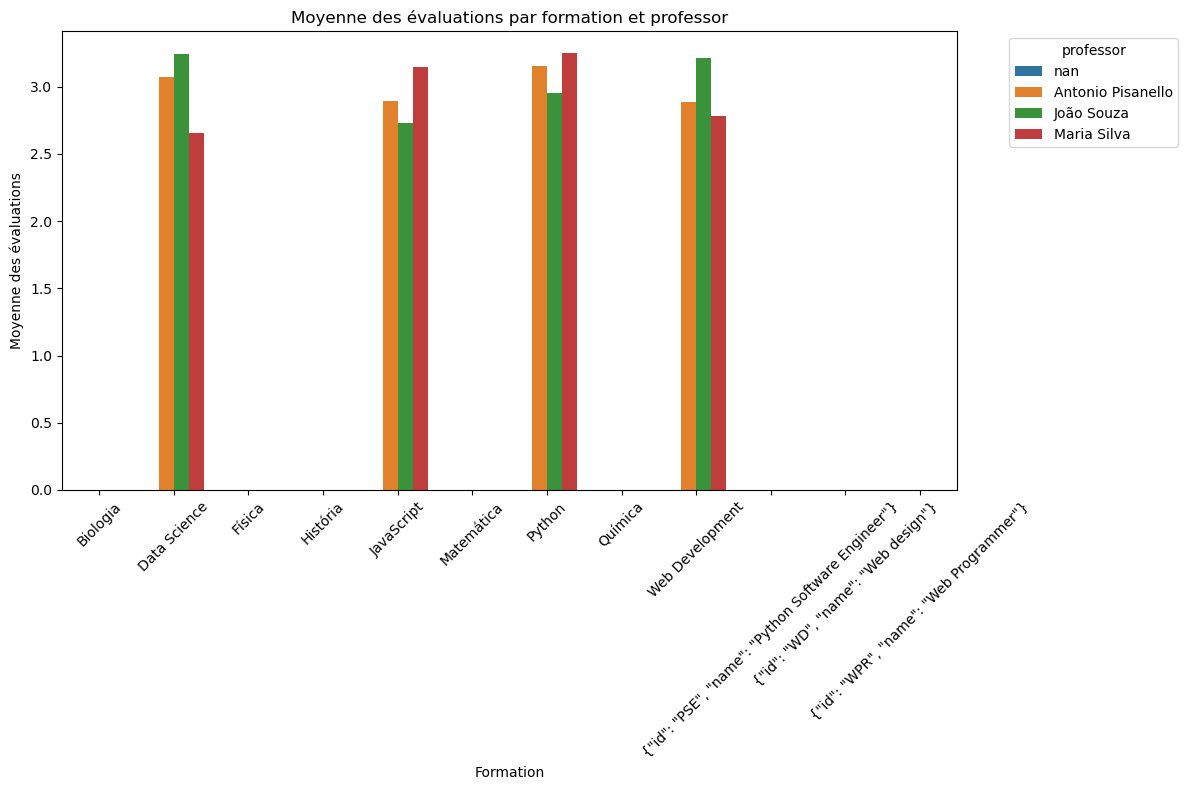

/var/folders/7b/yrnrc0bj463c9l_ssqndgvtw0000gn/T/ipykernel_26279/4052173873.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_ratings, x='Formationsuivie', y='rating', palette='viridis')


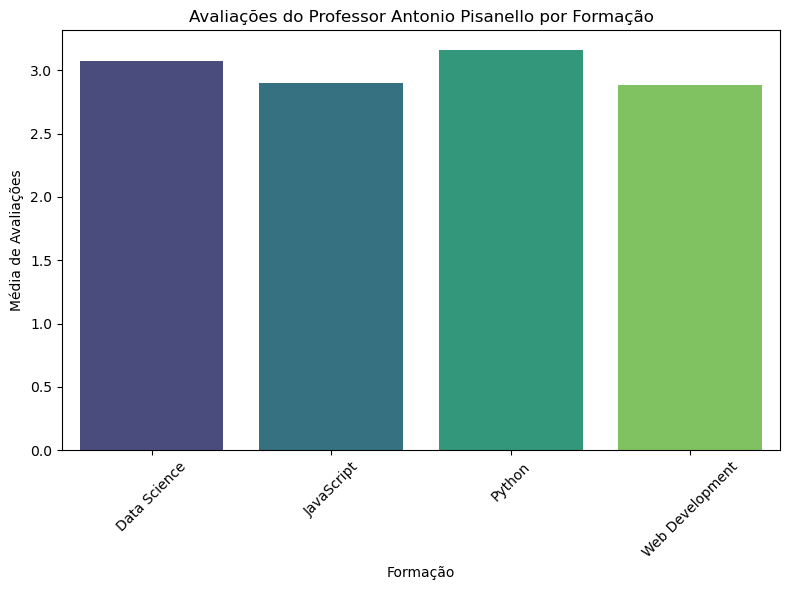

In [2]:
import os
import sys
import json
import random
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from pymongo import MongoClient

# Chemin du projet
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
if project_path not in sys.path:
    sys.path.append(project_path)

# Fonction pour se connecter à la base de données
def get_db():
    client = MongoClient('mongodb://localhost:27017/')
    db = client['sms_nomades']
    return db

# Classe pour l'analyse des données
class AnalyseRepository:
    def __init__(self):
        self.db = get_db()
        self.collection = self.db['evaluations']
    # Fonction pour insérer des données simulées dans la collection 'evaluations'
    def insert_sample_data(self, num_entries=100):
        """insérer des données simulées dans la collection 'evaluations'."""
        formations = ['JavaScript', 'Python', 'Data Science', 'Web Development']
        professors = ['Antonio Pisanello', 'Maria Silva', 'João Souza']
        for _ in range(num_entries):
            self.collection.insert_one({
                'Formationsuivie': random.choice(formations),
                'professor': random.choice(professors),
                'rating': random.randint(1, 5),  # Nota entre 1 e 5
                'Datesdelaformation': (datetime.now() - timedelta(days=random.randint(0, 365))).isoformat()
            })
        print(f"{num_entries} entrées simulées insérées avec succès.")

    def get_all_evaluations(self):
        return [evaluation for evaluation in self.collection.find()]
    
    def analyze_data(self):
        all_evaluations = self.get_all_evaluations()
        return all_evaluations

    def evaluations_to_dataframe(self, evaluations):
        """Convertir les évaluations en DataFrame."""
        df = pd.DataFrame(evaluations)
        
        # Normaliser les colonnes imbriquées
        for col in ['Formationsuivie', 'professor']:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: json.dumps(x) if isinstance(x, (dict, list)) else str(x))
        
        return df

    def plot_average_rating_per_formation(self, df):
        """Moyenne des évaluations par formation et professor."""
        if 'Formationsuivie' not in df.columns or 'professor' not in df.columns:
            print("Colonnes requises non trouvées!")
            return
        avg_ratings = df.groupby(['Formationsuivie', 'professor'])['rating'].mean().reset_index()
        plt.figure(figsize=(12, 8))
        sns.barplot(data=avg_ratings, x='Formationsuivie', y='rating', hue='professor')
        plt.title('Moyenne des évaluations par formation et professor')
        plt.xlabel('Formation')
        plt.ylabel('Moyenne des évaluations')
        plt.legend(title='professor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_professor_formation_comparison(self, df, professor_name):
        """Comparaison des évaluations d'un professor spécifique par formation."""
        if 'Formationsuivie' not in df.columns or 'professor' not in df.columns:
            print("Colonnes requises non trouvées!")
            return
        professor_data = df[df['professor'] == professor_name]
        if professor_data.empty:
            print(f"Nenhum dado encontrado para o professor {professor_name}.")
            return
        avg_ratings = professor_data.groupby('Formationsuivie')['rating'].mean().reset_index()
        plt.figure(figsize=(8, 6))
        sns.barplot(data=avg_ratings, x='Formationsuivie', y='rating', palette='viridis')
        plt.title(f'Avaliações do Professor {professor_name} por Formação')
        plt.xlabel('Formação')
        plt.ylabel('Média de Avaliações')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Código principal
if __name__ == "__main__":
    # Criar instância da classe
    repo = AnalyseRepository()

    # Inserir dados simulados
    repo.insert_sample_data(num_entries=100)

    # Realizar análise de dados
    all_evaluations = repo.analyze_data()

    # Converter avaliações para DataFrame
    df_all = repo.evaluations_to_dataframe(all_evaluations)

    # Verificar se o DataFrame não está vazio
    if not df_all.empty:
        # Gráfico 1: Média das Avaliações por Formação e Professor
        repo.plot_average_rating_per_formation(df_all)
        
        # Gráfico 2: Comparação de um professor específico
        repo.plot_professor_formation_comparison(df_all, "Antonio Pisanello")
    else:
        print("Aucune donnée à afficher.")
